Notebook for kaggle version

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay

from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers.keras_callbacks import KerasMetricCallback

from datasets import Dataset, DatasetDict

print(tf.__version__)
print(tf.config.list_physical_devices())

# startegy for training on parallel gpus
#mirrored_strategy = tf.distribute.MirroredStrategy()

d:\Programs\Anaconda\envs\anndl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.12.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Tutorials links:
- [Hugging face tutorial](https://huggingface.co/docs/transformers/tasks/sequence_classification)
- [Fine tuning tutorial](https://huggingface.co/learn/nlp-course/chapter3/3?fw=tf)

Import dataset

In [2]:
dataset = pd.read_csv('../input/edos-1m/EDOS 1M.csv')
X, y = dataset["uttr"], dataset["eb+_emot"]
sample_weights = dataset["label_confidence"]

classes = np.unique(y)

# print number of samples in each class
print(dataset.groupby(['eb+_emot']).size())



eb+_emot
acknowledging    138165
afraid            49285
agreeing          96562
angry             34924
annoyed           30072
anticipating     100433
anxious            8578
apprehensive      46727
ashamed           14797
caring            42806
confident         84918
consoling         17256
content           64569
devastated        17539
disappointed      18298
disgusted         15070
embarrassed       32338
encouraging       10329
excited           53756
faithful          25029
furious          169917
grateful          42222
guilty            30043
hopeful           54012
impressed         25045
jealous           20902
joyful            24282
lonely            16396
neutral           55932
nostalgic         20461
prepared          48883
proud             33365
questioning      841556
sad               66262
sentimental       20715
suggesting       101591
surprised         46022
sympathizing      38774
terrified         28730
trusting         134197
wishing          108668
dtype: 

# Preparation

In [3]:

list_X = X.to_list()
for i in tqdm(range(len(list_X))):
    uttr = list_X[i]
    words = uttr.split(" ")
    filtered_words = []
    for word in words:
        #filtering away all numbers -> not good
        if all(char.isalpha() for char in word):
            filtered_words.append(word)
    list_X[i] = ' '.join(filtered_words)
X = pd.Series(list_X)


100%|██████████| 2829426/2829426 [00:56<00:00, 49949.31it/s]


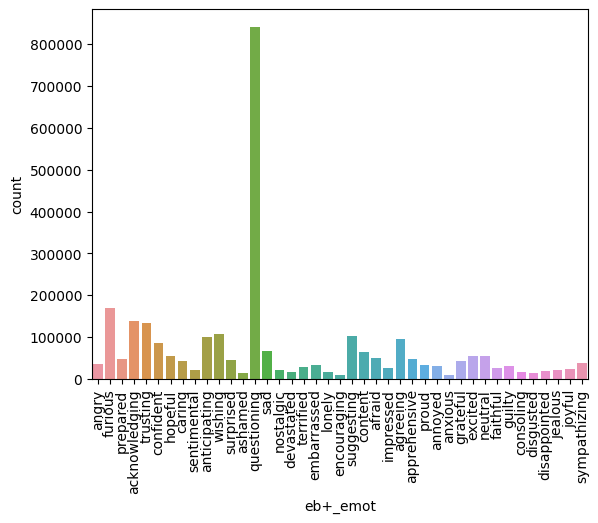

In [4]:
# plot classes distribution
sns.countplot(x='eb+_emot', data=dataset)
# write class names vertically
plt.xticks(rotation=90)
plt.show()


In [5]:
# train, validation and test split
train_X, no_train_X, train_y, no_train_y = train_test_split(X, y, test_size=0.3, stratify=y)
test_X, valid_X, test_y, valid_y = train_test_split(no_train_X, no_train_y, test_size=0.5, stratify=no_train_y)

print("train size: ", len(train_X))
print("validation size: ", len(valid_X))
print("test size: ", len(test_X))

train size:  1980598
validation size:  424414
test size:  424414


# Single utterance classification - Transformer-based model

In [6]:

'''
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
'''

# map expected ids to their labels and viceversa
id2label = dict(zip(range(len(classes)), classes))
label2id = dict(zip(classes, range(len(classes))))
print(id2label)

{0: 'acknowledging', 1: 'afraid', 2: 'agreeing', 3: 'angry', 4: 'annoyed', 5: 'anticipating', 6: 'anxious', 7: 'apprehensive', 8: 'ashamed', 9: 'caring', 10: 'confident', 11: 'consoling', 12: 'content', 13: 'devastated', 14: 'disappointed', 15: 'disgusted', 16: 'embarrassed', 17: 'encouraging', 18: 'excited', 19: 'faithful', 20: 'furious', 21: 'grateful', 22: 'guilty', 23: 'hopeful', 24: 'impressed', 25: 'jealous', 26: 'joyful', 27: 'lonely', 28: 'neutral', 29: 'nostalgic', 30: 'prepared', 31: 'proud', 32: 'questioning', 33: 'sad', 34: 'sentimental', 35: 'suggesting', 36: 'surprised', 37: 'sympathizing', 38: 'terrified', 39: 'trusting', 40: 'wishing'}


In [7]:
# building the datasets
train_data = Dataset.from_pandas(pd.DataFrame({"text": train_X, "label": np.argmax(pd.get_dummies(train_y).to_numpy(), axis=1)}), preserve_index=False)
valid_data = Dataset.from_pandas(pd.DataFrame({"text": valid_X, "label": np.argmax(pd.get_dummies(valid_y).to_numpy(), axis=1)}), preserve_index=False)
test_data = Dataset.from_pandas(pd.DataFrame({"text": test_X, "label": np.argmax(pd.get_dummies(test_y).to_numpy(), axis=1)}), preserve_index=False)

# shuffling is performed at the previous operation -> we need to redefine valid_y
valid_y = valid_data['label']

data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data
data['test'] = test_data

print(data['train'][0])
print(data['validation'][0])
print(data['test'][0])

{'text': 'Jass i what are y ou do i ng Why are y ou putti ng out the I ig hts', 'label': 32}
{'text': 'Listen the lad just lost his dad He angry We lost our dad We not running around waving knives', 'label': 3}
{'text': 'Pretty Okay I ready Good luck', 'label': 40}


In [8]:
# model metadata
model_name = "distilbert-base-uncased"

# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenize the data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_data = data.map(preprocess_function, batched=True)

print(tokenized_data["train"][0])


  0%|          | 0/1981 [00:00<?, ?ba/s]

  0%|          | 0/425 [00:00<?, ?ba/s]

  0%|          | 0/425 [00:00<?, ?ba/s]

{'text': 'Jass i what are y ou do i ng Why are y ou putti ng out the I ig hts', 'label': 32, 'input_ids': [101, 14855, 4757, 1045, 2054, 2024, 1061, 15068, 2079, 1045, 12835, 2339, 2024, 1061, 15068, 2404, 3775, 12835, 2041, 1996, 1045, 1045, 2290, 1044, 3215, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
# metadata
batch_size = 8
num_epochs = 3
batches_per_epoch = len(tokenized_data["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
print("Total train steps: " + str(total_train_steps))
print("Batches per epoch: " + str(batches_per_epoch))

#optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")
only_fine_tune = True

# convert datasets to a suitable format for tensorflow
tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_data["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)

num_train_steps = len(tf_train_dataset) * num_epochs
print("Number of training steps: " + str(num_train_steps))

lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps)

optimizer = Adam(learning_rate=lr_scheduler)

# create callback to save model at the end of each epoch
save_model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./models/model_checkpoint",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)
    
# apply parallel computation on kaggle
#with mirrored_strategy.scope():
# load the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes), id2label=id2label, label2id=label2id)

# leave only the classification layer trainable
if only_fine_tune:
    for i in range(1):
        model.layers[i].trainable = False

model.compile(
    optimizer = optimizer,
    loss = SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

model.summary()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Total train steps: 495148
Batches per epoch: 247574
Number of training steps: 495148


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  31529     
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,985,001
Trainable params: 622,121
Non-trainable params: 66,362,880
_________________________________________________________________


In [ ]:
# training
history = model.fit(
          x=tf_train_dataset,
          validation_data=tf_validation_dataset,
          epochs=num_epochs,                        
          callbacks = [save_model_callback]
)

# save the model
model.save_pretrained("./models/model1")


Epoch 1/3
247574/247574 [==============================] - 5754s 23ms/step - loss: 1.5124 - accuracy: 0.5527 - val_loss: 1.2726 - val_accuracy: 0.6069
Epoch 2/3
247574/247574 [==============================] - 5769s 23ms/step - loss: 1.3519 - accuracy: 0.5884 - val_loss: 1.2110 - val_accuracy: 0.6237
Epoch 3/3
247574/247574 [==============================] - 5892s 24ms/step - loss: 1.3178 - accuracy: 0.5970 - val_loss: 1.1934 - val_accuracy: 0.6283


In [ ]:
# validate the model
print('Results for BERT-based classifier:')
# validate the model -> accuracy should correspond to final val_accuracy
bert_y = np.argmax(model.predict(tf_validation_dataset)["logits"], axis=1)

print(classification_report(valid_y, bert_y, target_names=classes))